1) 데이터 준비 (tiff 이미지랑 csv파일)
2) stardist나 cellpose 사용해서 전체 cell들에 대해 segmentation
3) Cell feature들 추출 (by PathOmics)
4) 한 glom 안의 모든 세포들의 feature 집계 (이것도 PathOmics로 가능?)
5) CSV파일에 있는거 바탕으로 M0/M1 매칭
6) 머신러닝 모델 학습
7) 예측 및 해석

In [2]:
!pip install cellpose

  Using cached cellpose-3.1.1.1-py3-none-any.whl.metadata (22 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached torch-2.4.1-cp38-cp38-win_amd64.whl.metadata (27 kB)
  Using cached fastremap-1.15.1-cp38-cp38-win_amd64.whl.metadata (9.8 kB)
  Using cached imagecodecs-2023.3.16-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached roifile-2023.5.12-py3-none-any.whl.metadata (5.0 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached MarkupSafe-2.1.5-cp38-cp38-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached cellpose-3.1.1.1-py3-none-any.whl (225 kB)
Using cached torch-2.4.1-cp38-cp38-win_amd64.whl (199.4 MB)
Using cached fastremap-1.15.1-cp38-cp38-win_amd64.whl (676 kB)
Using cache

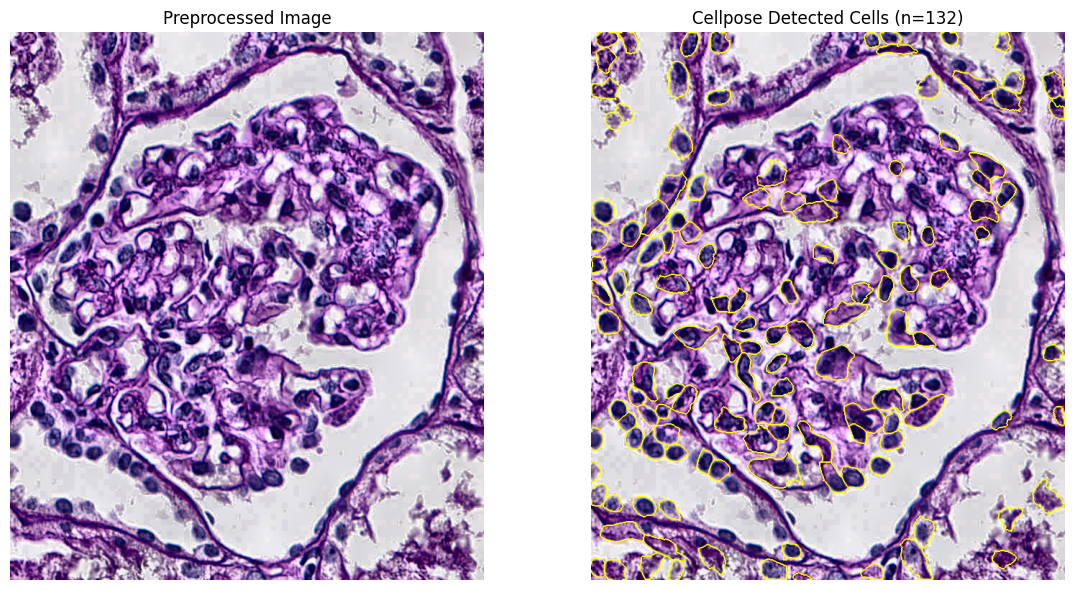

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from skimage.segmentation import find_boundaries

# 1️⃣ 이미지 경로 설정
image_path = r"C:\glom ML task\glom_patch\11_01_0001_PAS\11_01_0001_PAS_g00.tiff"

# 2️⃣ 이미지 로드 + RGB 변환
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 3️⃣ CLAHE 전처리 함수
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

# 4️⃣ CLAHE 적용
preprocessed = apply_clahe(img_rgb)

# 5️⃣ Cellpose 모델 로드
model = models.Cellpose(gpu=False, model_type='cyto')

# 6️⃣ 예측 실행
masks, flows, styles, diams = model.eval(preprocessed, channels=[0, 0])

# 7️⃣ 경계 시각화 (노란색으로)
boundaries = find_boundaries(masks)
overlay = preprocessed.copy()
overlay[boundaries] = [255, 255, 0]  # 노란색 (RGB)

# 8️⃣ 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed)
plt.title("Preprocessed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Cellpose Detected Cells (n={masks.max()})")
plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from cellpose import models

# 모델 로딩
model = models.Cellpose(gpu=False, model_type='cyto')

# CLAHE 전처리 함수
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

# 경로 설정
csv_path = r"C:\glom ML task\binary_labels.csv"
df = pd.read_csv(csv_path)
base_dir = r"C:\glom ML task\glom_patch"
save_dir = r"C:\glom ML task\segmentation_masks_cellpose"
os.makedirs(save_dir, exist_ok=True)

for i, row in tqdm(df.iterrows(), total=len(df)):
    rel_path = row["filepath"]
    img_path = os.path.join(base_dir, rel_path)
    
    # 파일 이름만 추출
    name = os.path.basename(rel_path).replace(".tiff", ".npz")

    # 이미지 로드
    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ 이미지 로드 실패: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = apply_clahe(image)

    # Cellpose segmentation
    masks, flows, styles, diams = model.eval(image, channels=[0, 0])

    # 저장
    np.savez_compressed(os.path.join(save_dir, name), masks=masks, diameter=diams)

print("✅ segmentation mask 저장 완료!")

100%|██████████| 1480/1480 [3:59:52<00:00,  9.72s/it]  

✅ segmentation mask 저장 완료!


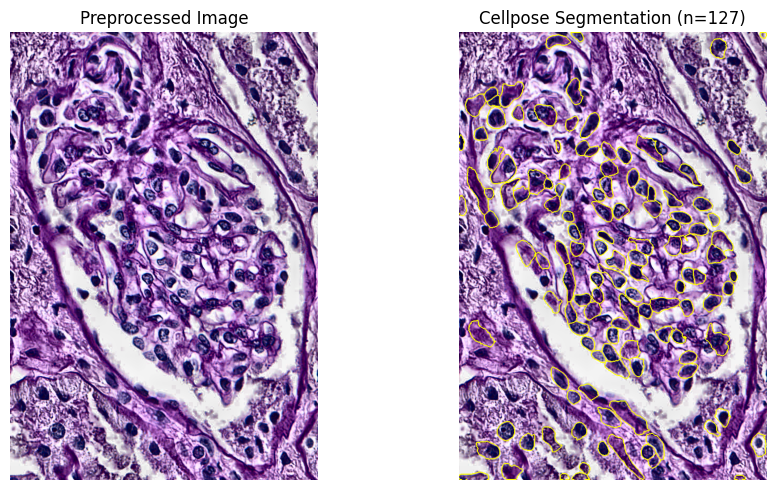

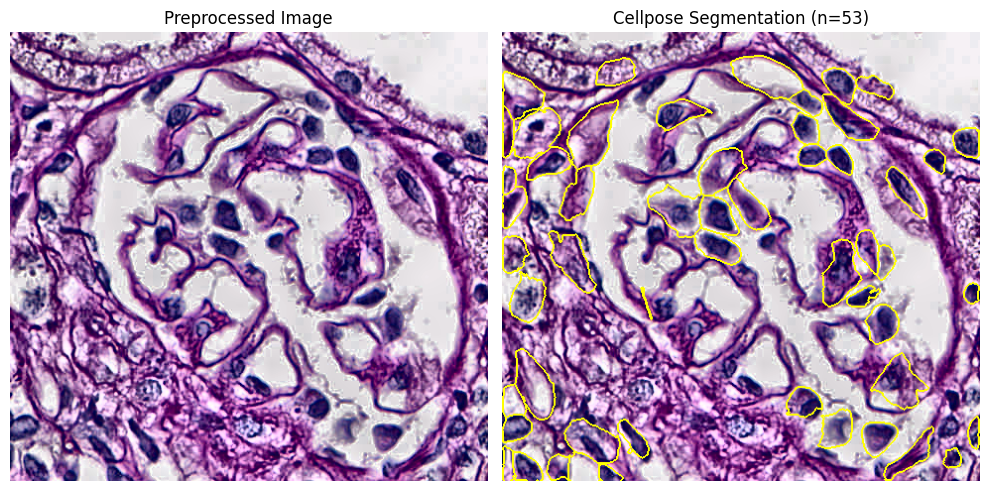

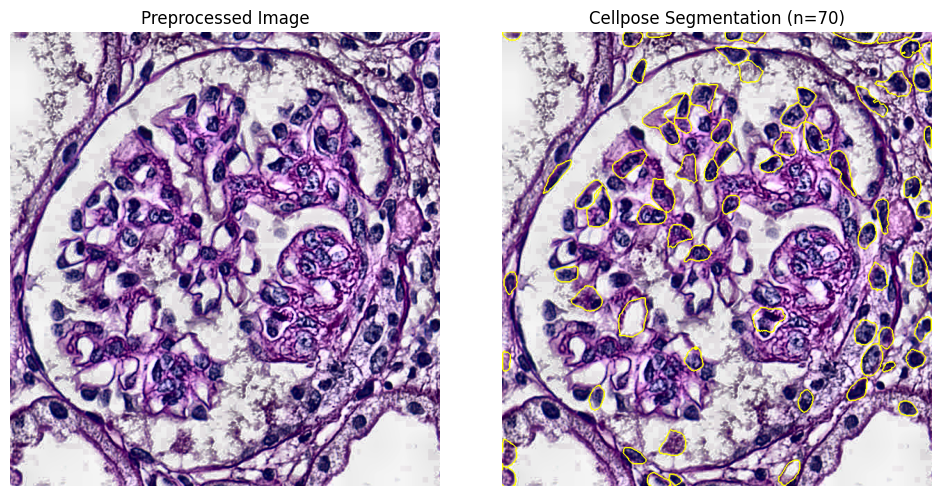

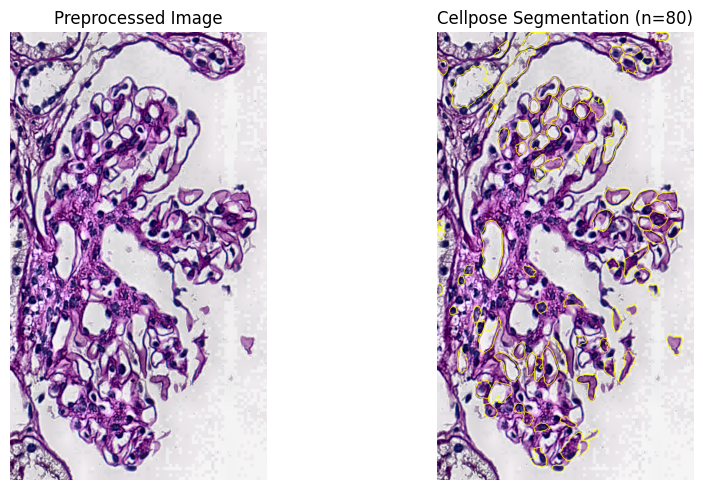

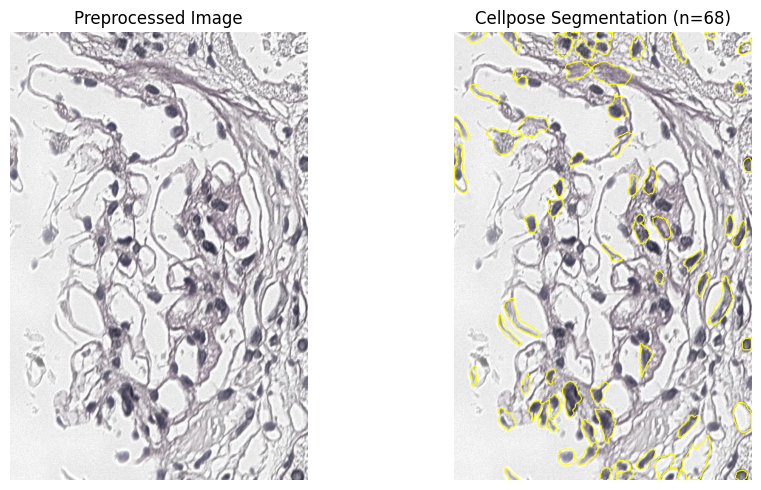

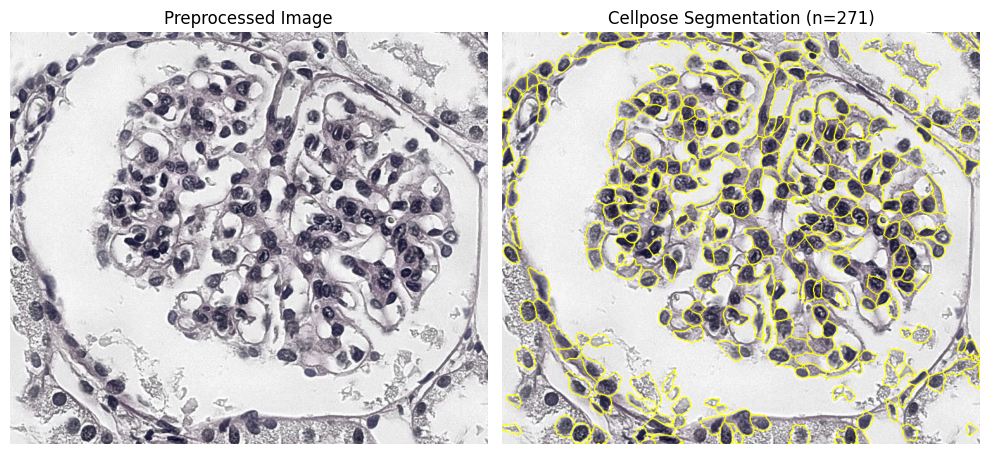

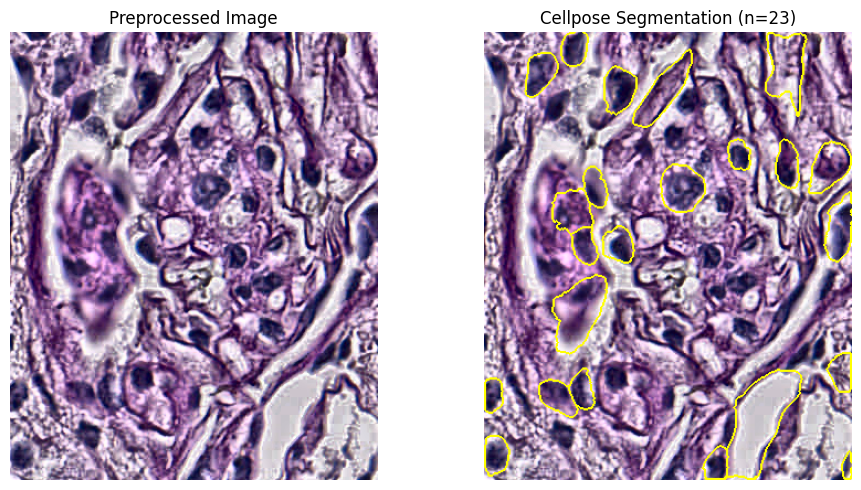

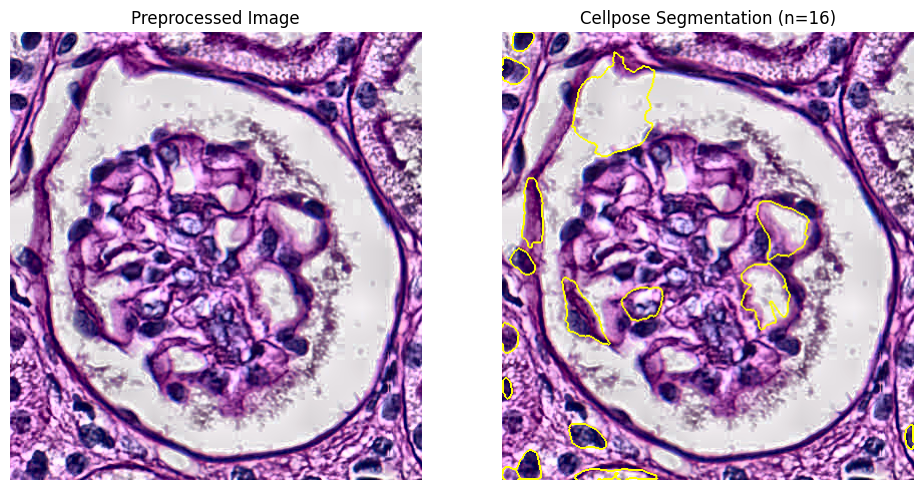

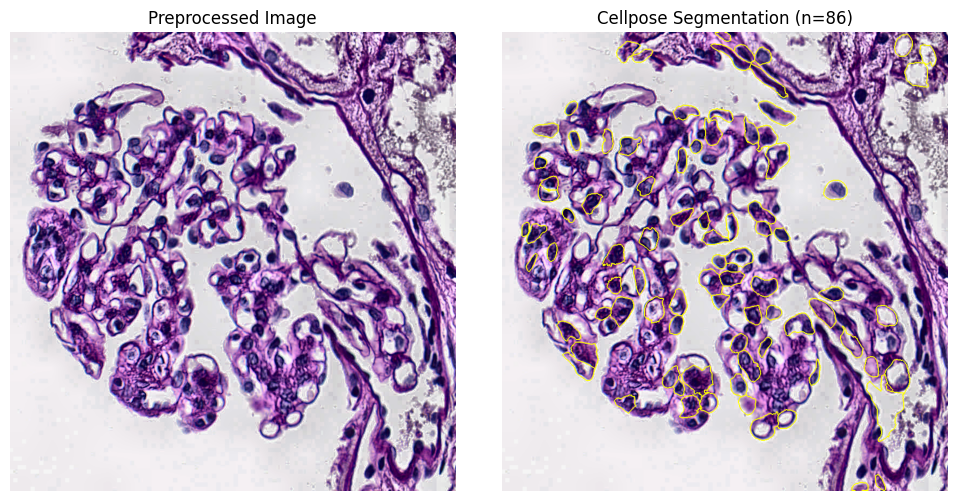

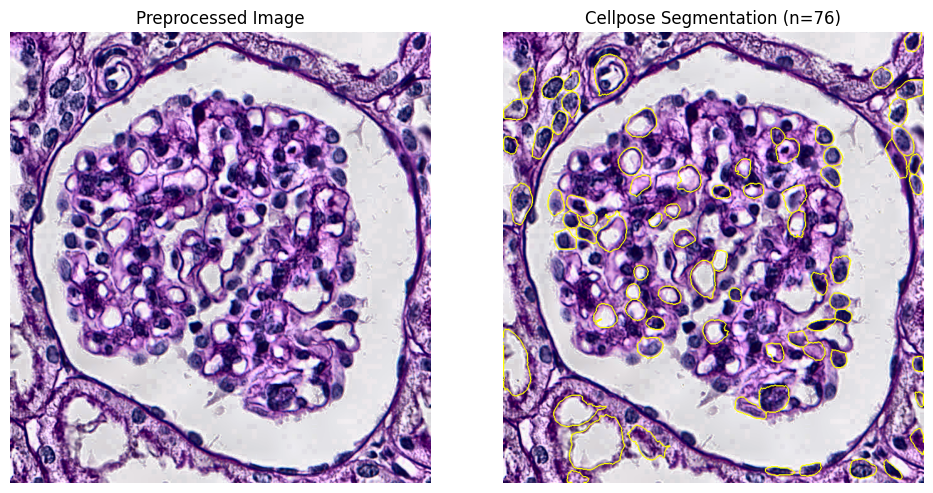

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.segmentation import find_boundaries

# 기본 경로
base_img_dir = r"C:\glom ML task\glom_patch"
mask_dir = r"C:\glom ML task\segmentation_masks_cellpose"
csv_path = r"C:\glom ML task\binary_labels.csv"

# CSV 불러오기
df = pd.read_csv(csv_path)

# CLAHE 함수
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

# 5장 무작위 선택
sample_df = df.sample(n=10, random_state=42)

# 시각화
for _, row in sample_df.iterrows():
    rel_path = row["filepath"]
    img_path = os.path.join(base_img_dir, rel_path)
    npz_name = os.path.basename(rel_path).replace(".tiff", ".npz")
    subfolder = os.path.dirname(rel_path)
    npz_path = os.path.join(mask_dir, subfolder, npz_name)

    # 이미지 로드
    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ 이미지 로드 실패: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = apply_clahe(image)

    # 마스크 로드
    if not os.path.exists(npz_path):
        print(f"❌ 마스크 없음: {npz_path}")
        continue
    data = np.load(npz_path)
    masks = data["masks"]

    # 경계
    boundaries = find_boundaries(masks)
    overlay = image.copy()
    overlay[boundaries] = [255, 255, 0]  # 노란색

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Preprocessed Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Cellpose Segmentation (n={masks.max()})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


Cell들의 feature 추출

In [27]:
import numpy as np
import cv2
import os
import pandas as pd
from skimage.measure import regionprops_table
from scipy.spatial import distance_matrix

# 🔹 마스크 경로
npz_path = r"C:\glom ML task\segmentation_masks_cellpose\11_01_0001_PAS\11_01_0001_PAS_g00.npz"

# 🔹 원본 이미지 경로 (density 계산용)
image_path = r"C:\glom ML task\glom_patch\11_01_0001_PAS\11_01_0001_PAS_g00.tiff"

# 🔸 이미지 크기 (density 계산용)
img = cv2.imread(image_path)
h, w = img.shape[:2]

# 🔹 마스크 로딩
data = np.load(npz_path)
masks = data["masks"]

# 🔹 regionprops feature 계산
props = regionprops_table(masks, properties=["area", "eccentricity", "solidity", "centroid"])
df_cell = pd.DataFrame(props)

# 🔸 거리 계산
coords = df_cell[["centroid-0", "centroid-1"]].values
if len(coords) > 1:
    dists = distance_matrix(coords, coords)
    min_dists = np.sort(dists, axis=1)[:, 1]  # 자기 자신 제외한 최소거리
    mean_min_dist = np.mean(min_dists)
else:
    mean_min_dist = 0

# 🔸 세포 밀도
cell_density = len(df_cell) / (h * w)

# 🔸 최종 요약 결과
summary = {
    "cell_count": len(df_cell),
    "mean_area": df_cell["area"].mean(),
    "std_area": df_cell["area"].std(),
    "mean_solidity": df_cell["solidity"].mean(),
    "mean_eccentricity": df_cell["eccentricity"].mean(),
    "mean_min_dist": mean_min_dist,
    "density": cell_density
}

# 🔸 결과 출력
# 🔟 출력
print("📊 Glom-level feature summary:")
for k, v in summary.items():
    if k == "density":
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v:.4f}")

📊 Glom-level feature summary:
cell_count: 132.0000
mean_area: 707.2955
std_area: 337.8816
mean_solidity: 0.9287
mean_eccentricity: 0.7237
mean_min_dist: 36.6868
density: 0.000263


전체 이미지에 대해 3번 (Cell feature 추출) 적용용

In [28]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from skimage.measure import regionprops_table
from scipy.spatial import distance_matrix

# 🔹 경로 설정
csv_path = r"C:\glom ML task\binary_labels.csv"
df_meta = pd.read_csv(csv_path)
base_dir_img = r"C:\glom ML task\glom_patch"
base_dir_npz = r"C:\glom ML task\segmentation_masks_cellpose"
save_path_csv = r"C:\glom ML task\ml_features_cellpose.csv"

results = []

for i, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    rel_path = row["filepath"]
    label = row["label"]
    
    # 원본 이미지 경로
    img_path = os.path.join(base_dir_img, rel_path)
    if not os.path.exists(img_path):
        print(f"❌ 이미지 없음: {img_path}")
        continue

    # npz 경로 (확장자 변경 및 폴더 처리)
    name = os.path.basename(rel_path).replace(".tiff", ".npz")
    folder = os.path.basename(os.path.dirname(rel_path))
    npz_path = os.path.join(base_dir_npz, folder, name)
    
    if not os.path.exists(npz_path):
        print(f"❌ 마스크 없음: {npz_path}")
        continue

    # 이미지 크기 로드
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # 마스크 로딩
    data = np.load(npz_path)
    masks = data["masks"]

    # regionprops feature 계산
    props = regionprops_table(masks, properties=["area", "eccentricity", "solidity", "centroid"])
    df_cell = pd.DataFrame(props)

    # 거리 계산
    coords = df_cell[["centroid-0", "centroid-1"]].values
    if len(coords) > 1:
        dists = distance_matrix(coords, coords)
        min_dists = np.sort(dists, axis=1)[:, 1]
        mean_min_dist = np.mean(min_dists)
    else:
        mean_min_dist = 0

    # 밀도 계산
    density = len(df_cell) / (h * w)

    # 결과 저장
    results.append({
        "filepath": rel_path,
        "label": label,
        "cell_count": len(df_cell),
        "mean_area": df_cell["area"].mean(),
        "std_area": df_cell["area"].std(),
        "mean_solidity": df_cell["solidity"].mean(),
        "mean_eccentricity": df_cell["eccentricity"].mean(),
        "mean_min_dist": mean_min_dist,
        "density": density
    })

# 최종 저장
df_result = pd.DataFrame(results)
df_result.to_csv(save_path_csv, index=False)
print("✅ Cellpose 기반 feature CSV 저장 완료:", save_path_csv)

100%|██████████| 1480/1480 [05:34<00:00,  4.43it/s]

✅ Cellpose 기반 feature CSV 저장 완료: C:\glom ML task\ml_features_cellpose.csv


csv 파일 잘 만들어졌는지 확인

In [4]:
import pandas as pd

df = pd.read_csv(r"C:\glom ML task\ml_features_cellpose.csv")
print("🔹 Shape:", df.shape)
print("🔹 Columns:", df.columns.tolist())
df.head()

🔹 Shape: (1480, 11)
🔹 Columns: ['filepath', 'label', 'cell_count', 'mean_area', 'std_area', 'mean_solidity', 'mean_eccentricity', 'mean_min_dist', 'density', 'filepath_norm', 'tvt']


filepath  label  cell_count   mean_area  \
0  11_01_0001_PAS/11_01_0001_PAS_g00.tiff      1         132  707.295455   
1  11_01_0001_PAS/11_01_0001_PAS_g01.tiff      1          60  787.666667   
2  11_01_0001_PAS/11_01_0001_PAS_g02.tiff      0          92  727.206522   
3  11_01_0001_PAS/11_01_0001_PAS_g03.tiff      1         133  701.428571   
4  11_01_0001_PAS/11_01_0001_PAS_g06.tiff      1         150  577.920000   

     std_area  mean_solidity  mean_eccentricity  mean_min_dist   density  \
0  337.881630       0.928653           0.723695      36.686756  0.000263   
1  393.522668       0.932929           0.725165      45.688592  0.000147   
2  330.464759       0.929556           0.723250      37.323814  0.000263   
3  347.078855       0.932934           0.744219      35.107865  0.000264   
4  308.772011       0.932603           0.733447      33.186009  0.000272   

                            filepath_norm    tvt  
0  11_01_0001_PAS\11_01_0001_PAS_g00.tiff  valid  
1  11_01_0001_PAS\11_01_0001_PAS_g01.tiff  valid  
2  11_01_0001_PAS\11_01_0001_PAS_g02.tiff  valid  
3  11_01_0001_PAS\11_01_0001_PAS_g03.tiff  valid  
4  11_01_0001_PAS\11_01_0001_PAS_g06.tiff  valid

In [42]:
import os
import pandas as pd

# 파일 경로
csv_feat_path = r"C:\glom ML task\ml_features_cellpose.csv"
csv_meta_path = r"C:\glom ML task\241121_updated_m0m1e1.csv"

# 데이터 불러오기
df_feat = pd.read_csv(csv_feat_path)
df_meta = pd.read_csv(csv_meta_path)

# filepath_norm 생성
df_meta["filepath_norm"] = df_meta["filepath"].apply(lambda x: os.path.normpath(x).split("patch" + os.sep)[-1])
df_feat["filepath_norm"] = df_feat["filepath"].apply(lambda x: os.path.normpath(x))

# 병합
df_merged = pd.merge(df_feat, df_meta[["filepath_norm", "tvt"]], on="filepath_norm", how="inner")

In [43]:
# 중복 컬럼 정리
df_merged = df_merged.drop(columns=["tvt_x"])
df_merged = df_merged.rename(columns={"tvt_y": "tvt"})

# 분포 확인
print("📊 tvt 분포:")
print(df_merged["tvt"].value_counts())

📊 tvt 분포:
tvt
train    991
valid    249
test     240
Name: count, dtype: int64


In [44]:
# 저장 경로
save_path = r"C:\glom ML task\ml_features_cellpose.csv"

# 저장
df_merged.to_csv(save_path, index=False)
print("✅ CSV 저장 완료:", save_path)

✅ CSV 저장 완료: C:\glom ML task\ml_features_cellpose.csv


In [2]:
import pandas as pd
# 저장된 CSV 파일 확인
df_check = pd.read_csv(r"C:\glom ML task\ml_features_cellpose.csv")

# 상위 5개 행 출력
print(df_check.head())

# 컬럼 정보 및 행 수 확인
print("\n🔎 Shape:", df_check.shape)
print("🧱 Columns:", df_check.columns.tolist())

# tvt 분포 확인
print("\n📊 tvt 분포:")
print(df_check["tvt"].value_counts())

                                 filepath  label  cell_count   mean_area  \
0  11_01_0001_PAS/11_01_0001_PAS_g00.tiff      1         132  707.295455   
1  11_01_0001_PAS/11_01_0001_PAS_g01.tiff      1          60  787.666667   
2  11_01_0001_PAS/11_01_0001_PAS_g02.tiff      0          92  727.206522   
3  11_01_0001_PAS/11_01_0001_PAS_g03.tiff      1         133  701.428571   
4  11_01_0001_PAS/11_01_0001_PAS_g06.tiff      1         150  577.920000   

     std_area  mean_solidity  mean_eccentricity  mean_min_dist   density  \
0  337.881630       0.928653           0.723695      36.686756  0.000263   
1  393.522668       0.932929           0.725165      45.688592  0.000147   
2  330.464759       0.929556           0.723250      37.323814  0.000263   
3  347.078855       0.932934           0.744219      35.107865  0.000264   
4  308.772011       0.932603           0.733447      33.186009  0.000272   

                            filepath_norm    tvt  
0  11_01_0001_PAS\11_01_0001_PAS_g0

In [46]:
print(df.columns.tolist())

['filepath', 'label', 'cell_count', 'mean_area', 'std_area', 'mean_solidity', 'mean_eccentricity', 'mean_min_dist', 'density', 'tvt_x', 'filepath_norm', 'tvt_y']


In [48]:
feature_cols = ['filepath', 'label', 'cell_count', 'mean_area', 'std_area', 'mean_solidity', 'mean_eccentricity', 'mean_min_dist', 'density', 'tvt_x', 'filepath_norm', 'tvt_y']
print(df[feature_cols].isnull().sum())

filepath                0
label                   0
cell_count              0
mean_area               0
std_area                0
mean_solidity           0
mean_eccentricity       0
mean_min_dist           0
density                 0
tvt_x                1480
filepath_norm           0
tvt_y                   0
dtype: int64


In [ ]:
# 1. 'tvt_x'는 필요 없으므로 제거
df = df.drop(columns=["tvt_x"])

# 2. 'tvt_y'를 'tvt'로 깔끔하게 바꾸기
df = df.rename(columns={"tvt_y": "tvt"})

# 3. 다시 확인
print("📊 tvt 분포:")
print(df["tvt"].value_counts())

머신러닝 모델 학습


✅ [Validation] Accuracy: 0.6426
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       148
           1       0.64      0.27      0.38       101

    accuracy                           0.64       249
   macro avg       0.64      0.58      0.56       249
weighted avg       0.64      0.64      0.60       249



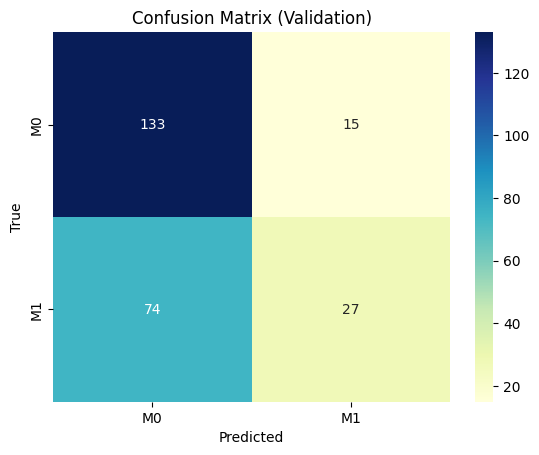

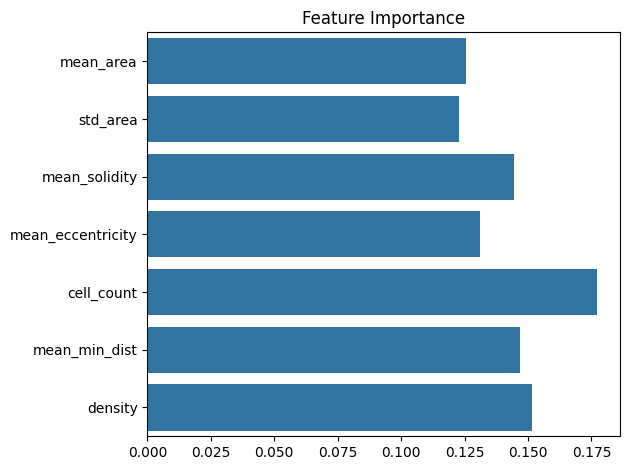


 [Test] Accuracy: 0.6125
              precision    recall  f1-score   support

           0       0.64      0.81      0.71       143
           1       0.53      0.32      0.40        97

    accuracy                           0.61       240
   macro avg       0.59      0.57      0.56       240
weighted avg       0.60      0.61      0.59       240



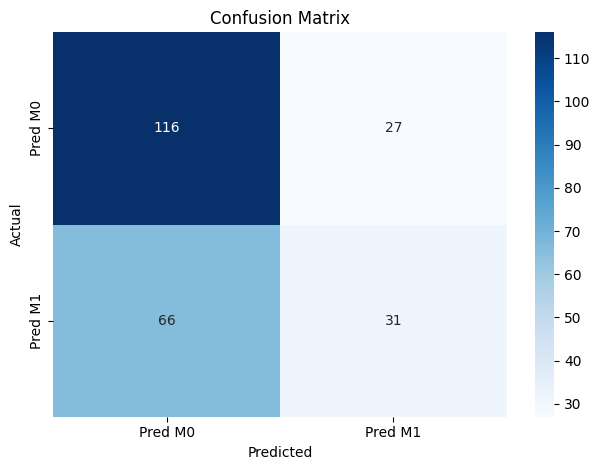

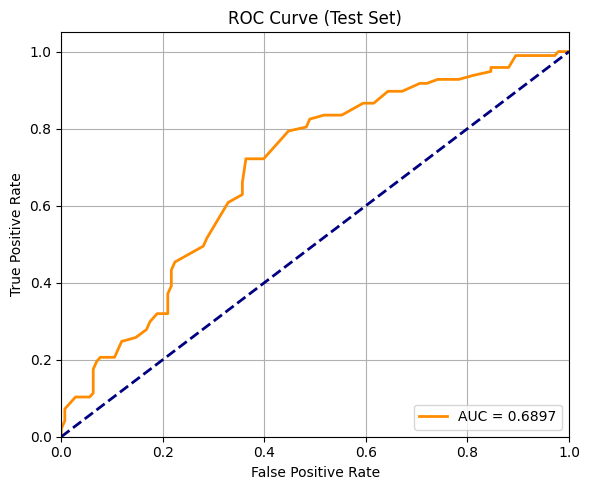

 [Test] ROC AUC: 0.6897


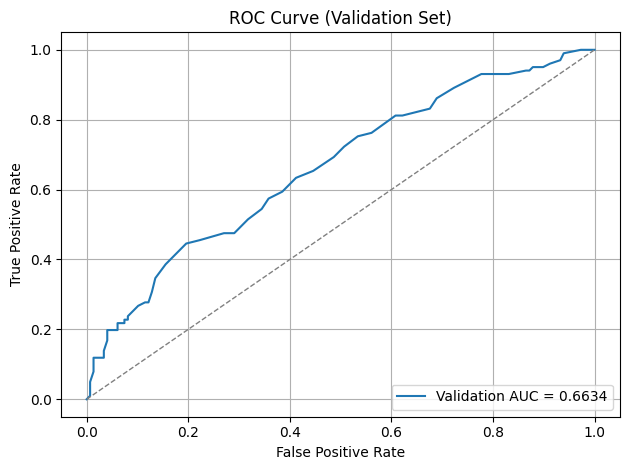

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd

df = pd.read_csv(r"C:\glom ML task\ml_features_cellpose.csv")

# ✅ feature 컬럼
feature_cols = [
    "mean_area", "std_area", "mean_solidity", "mean_eccentricity",
    "cell_count", "mean_min_dist", "density"
]

# ✅ 데이터 분할
X_train = df[df["tvt"] == "train"][feature_cols]
y_train = df[df["tvt"] == "train"]["label"]

X_valid = df[df["tvt"] == "valid"][feature_cols]
y_valid = df[df["tvt"] == "valid"]["label"]

X_test = df[df["tvt"] == "test"][feature_cols]
y_test = df[df["tvt"] == "test"]["label"]

# ✅ 모델 학습
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced",random_state=42)
rf.fit(X_train, y_train)

# ✅ Validation 평가
y_pred_valid = rf.predict(X_valid)
print(f"\n✅ [Validation] Accuracy: {accuracy_score(y_valid, y_pred_valid):.4f}")
print(classification_report(y_valid, y_pred_valid))

# ✅ 혼동 행렬 (valid 기준)
cm = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["M0", "M1"], yticklabels=["M0", "M1"])
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Feature importance
importances = rf.feature_importances_
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# ✅ Test 평가 (최종 결과)
y_pred_test = rf.predict(X_test)
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred M0", "Pred M1"], yticklabels=["Pred M0", "Pred M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 예측 확률값 (M1 클래스에 대한 확률)
y_proba_test = rf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f" [Test] ROC AUC: {roc_auc:.4f}")

y_proba_valid = rf.predict_proba(X_valid)[:, 1]
fpr_v, tpr_v, _ = roc_curve(y_valid, y_proba_valid)
roc_auc_v = auc(fpr_v, tpr_v)

plt.plot(fpr_v, tpr_v, label=f"Validation AUC = {roc_auc_v:.4f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#RandomForest SMOTE 미적용 시 + 전체 feature에 대해 

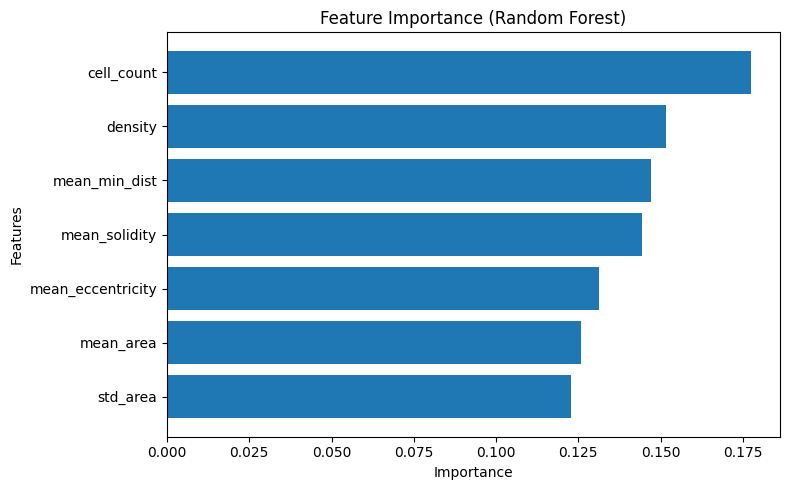

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# feature 이름
feature_names = X_train.columns

# 중요도 추출
importances_rf = rf.feature_importances_

# Series로 변환 후 정렬
feat_imp_rf = pd.Series(importances_rf, index=feature_names).sort_values()

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(feat_imp_rf.index, feat_imp_rf.values)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ [Validation] Accuracy: 0.6305
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       148
           1       0.58      0.33      0.42       101

    accuracy                           0.63       249
   macro avg       0.61      0.58      0.57       249
weighted avg       0.62      0.63      0.60       249



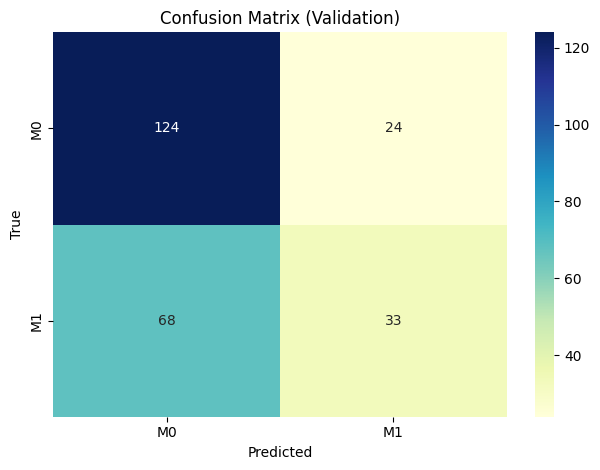

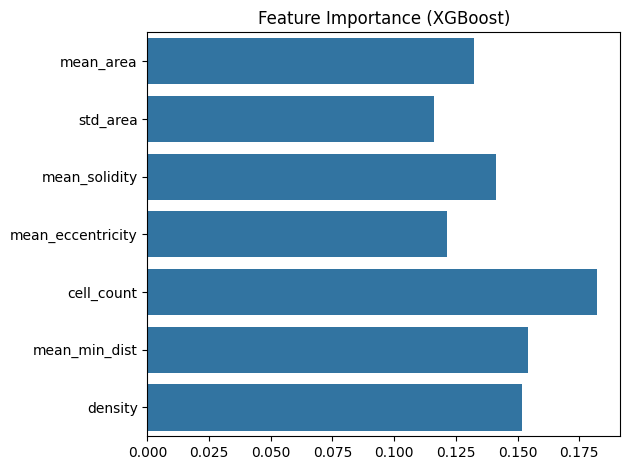


 [Test] Accuracy: 0.6167
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       143
           1       0.54      0.38      0.45        97

    accuracy                           0.62       240
   macro avg       0.59      0.58      0.58       240
weighted avg       0.60      0.62      0.60       240



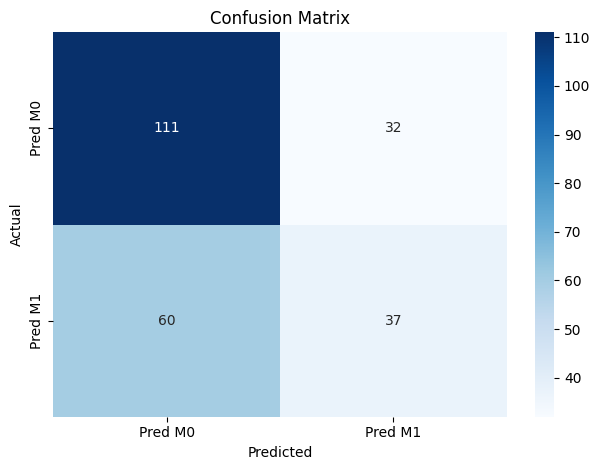

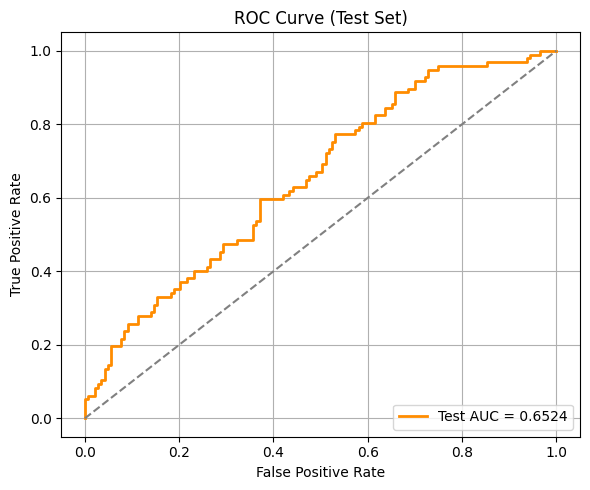

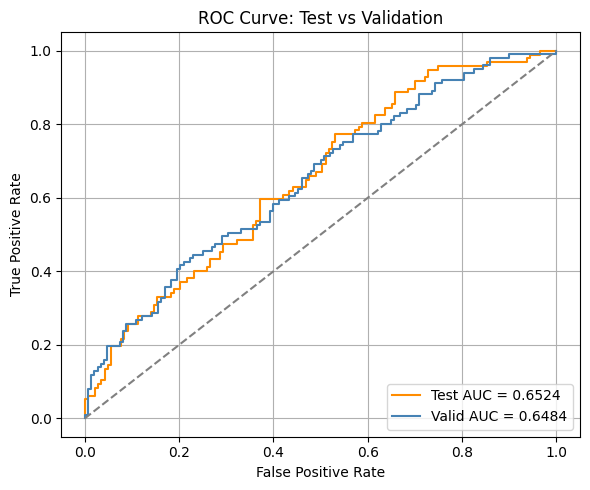

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 CSV 파일 불러오기
csv_path = r"C:\glom ML task\ml_features_cellpose.csv"
df = pd.read_csv(csv_path)

# ✅ feature 컬럼
feature_cols = [
    "mean_area", "std_area", "mean_solidity", "mean_eccentricity",
    "cell_count", "mean_min_dist", "density"
]

# ✅ 데이터 분할
X_train = df[df["tvt"] == "train"][feature_cols]
y_train = df[df["tvt"] == "train"]["label"]

X_valid = df[df["tvt"] == "valid"][feature_cols]
y_valid = df[df["tvt"] == "valid"]["label"]

X_test = df[df["tvt"] == "test"][feature_cols]
y_test = df[df["tvt"] == "test"]["label"]

# ✅ XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# ✅ Validation 평가
y_pred_valid = xgb.predict(X_valid)
print(f"\n✅ [Validation] Accuracy: {accuracy_score(y_valid, y_pred_valid):.4f}")
print(classification_report(y_valid, y_pred_valid))

# ✅ 혼동 행렬 (Validation)
cm_val = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["M0", "M1"], yticklabels=["M0", "M1"])
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ✅ Feature importance
importances = xgb.feature_importances_
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# ✅ Test 평가
y_pred_test = xgb.predict(X_test)
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred M0", "Pred M1"], yticklabels=["Pred M0", "Pred M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ ROC Curve (Test)
y_proba_test = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Test AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Validation ROC Curve
y_proba_valid = xgb.predict_proba(X_valid)[:, 1]
fpr_v, tpr_v, _ = roc_curve(y_valid, y_proba_valid)
roc_auc_v = auc(fpr_v, tpr_v)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Test AUC = {roc_auc:.4f}", color="darkorange")
plt.plot(fpr_v, tpr_v, label=f"Valid AUC = {roc_auc_v:.4f}", color="steelblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Test vs Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

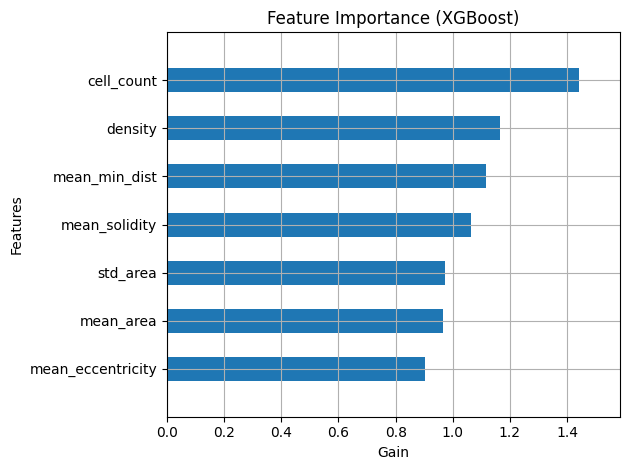

In [14]:
# XGBoost 내장 시각화 활용 (또는 직접 시각화도 가능)
import xgboost as xgb

xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

xgb.plot_importance(xgb_clf, importance_type='gain', show_values=False, max_num_features=10,
                    title="Feature Importance (XGBoost)", xlabel="Gain", height=0.5)
plt.tight_layout()
plt.show()

SHAP 해석 

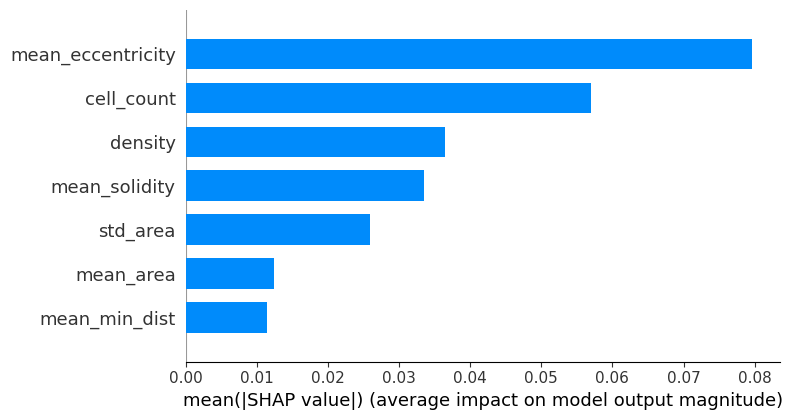

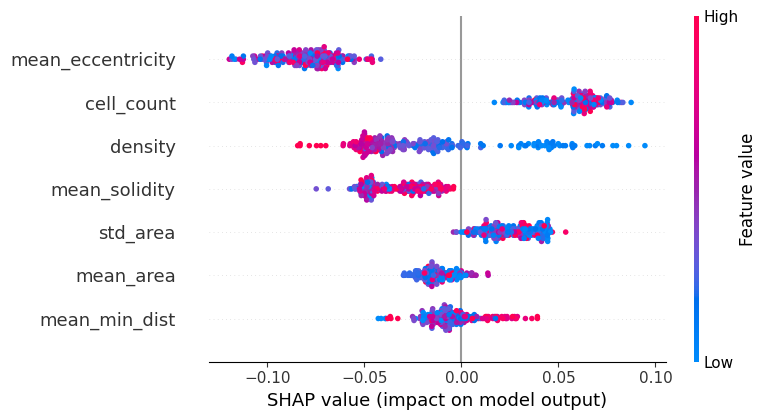

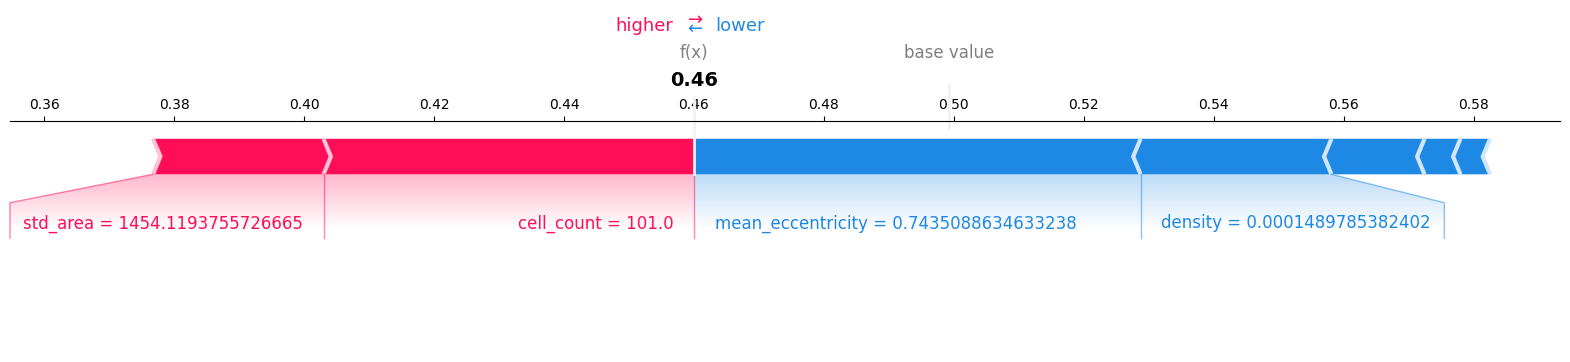

✅ force plot 저장 완료! ➜ C:\glom ML task\cellpose_rf_shap_force_plot.html


In [22]:
#Random Forest 기준
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 1. SHAP explainer 생성 (Random Forest 기준)
explainer = shap.TreeExplainer(rf)

# ✅ 2. SHAP 값 계산 (클래스 1 기준)
shap_values = explainer.shap_values(X_test)

# ✅ 3. Summary plot (전체 feature 중요도: bar plot)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# ✅ 4. Summary plot (전체 feature 중요도: dot plot)
shap.summary_plot(shap_values[1], X_test)

# ✅ 5. 개별 예측 해석 예시 (첫 번째 샘플)
idx = 0  # 보고 싶은 test 샘플 index
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx], X_test.iloc[idx], matplotlib=True)

# ✅ 6. Force Plot을 HTML로 저장 (랜덤 포레스트 + 첫 번째 테스트 샘플)
idx = 0  # 예시로 볼 샘플 index
shap.initjs()

# force plot 생성
force_html_rf = shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1][idx],
    features=X_test.iloc[idx],
    feature_names=feature_cols,
    matplotlib=False
)

# HTML 저장 경로
save_path_rf = r"C:\glom ML task\cellpose_rf_shap_force_plot.html"
shap.save_html(save_path_rf, force_html_rf)
print(f"✅ force plot 저장 완료! ➜ {save_path_rf}")

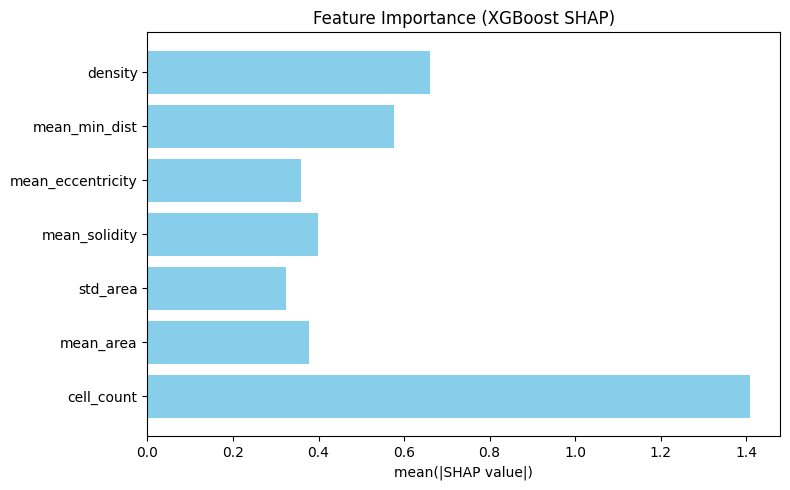

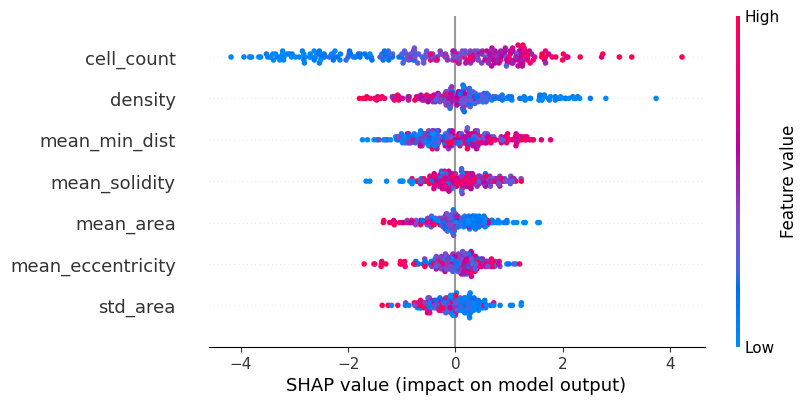

✅ force plot 저장 완료! ➜ C:\glom ML task\cellpose_xgb_shap_force_plot.html


In [20]:
#XGBoost 기준
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 💾 데이터 로드
df = pd.read_csv(r"C:\glom ML task\ml_features_cellpose.csv")

# 🎯 특성과 타겟 정의
feature_cols = ['cell_count', 'mean_area', 'std_area', 'mean_solidity', 'mean_eccentricity', 'mean_min_dist', 'density']
X = df[feature_cols]
y = df['label']
tvt = df['tvt']

# 🔀 Train/Valid/Test 나누기
X_train, X_valid, X_test = X[tvt == 'train'], X[tvt == 'valid'], X[tvt == 'test']
y_train, y_valid, y_test = y[tvt == 'train'], y[tvt == 'valid'], y[tvt == 'test']

# ✅ 1. XGBoost 모델 학습
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# ✅ 2. SHAP explainer 초기화
explainer = shap.Explainer(xgb_clf, X_train)

# ✅ 3. SHAP 값 계산
shap_values = explainer(X_test)

# ✅ 4. 수동 Bar Plot (파란색 막대)
shap_mean = np.abs(shap_values.values).mean(axis=0)
plt.figure(figsize=(8, 5))
plt.barh(X_test.columns, shap_mean, color='skyblue')
plt.xlabel("mean(|SHAP value|)")
plt.title("Feature Importance (XGBoost SHAP)")
plt.tight_layout()
plt.show()

# ✅ 5. SHAP Summary Plot (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

# ✅ 6. Force Plot 생성 (예시: 첫 번째 테스트 샘플)
shap.initjs()  # JS 초기화
force_html = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0].values,
    features=X_test.iloc[0],
    feature_names=feature_cols,
    matplotlib=False
)

# ✅ 7. HTML 파일로 저장 (로컬에서도 열 수 있음)
save_path = r"C:\glom ML task\cellpose_xgb_shap_force_plot.html"
shap.save_html(save_path, force_html)
print(f"✅ force plot 저장 완료! ➜ {save_path}")


8주차 주간발표를 위해 추가한 것들
Cellpose cell segmentation -> boxplot / PCA 분석 -> feature들 가지고 RF/XGB 성능 개선 시도

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import os

# -------------------------------------
# 1. CSV 파일 경로
# -------------------------------------
csv_path = "C:/glom ML task/ml_features_cellpose.csv"  # 네 로컬 경로로 수정 필요
df = pd.read_csv(csv_path)

# -------------------------------------
# 2. 분석 대상 feature만 선택
# 숫자형이며 filepath, label, filepath_norm, tvt 제외
# -------------------------------------
exclude_cols = ['filepath', 'filepath_norm', 'label', 'tvt']
feature_cols = df.drop(columns=exclude_cols).select_dtypes(include='number').columns

# -------------------------------------
# 3. 결과 저장 폴더 생성
# -------------------------------------
output_dir = "univariate_analysis_cellpose"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------
# 4. 단변량 분석
# -------------------------------------
results = []
sns.set(style="whitegrid")

for feature in feature_cols:
    group_m0 = df[df['label'] == 0][feature]
    group_m1 = df[df['label'] == 1][feature]
    
    # t-test
    t_stat, p_value = ttest_ind(group_m0, group_m1, equal_var=False)

    # boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="label", y=feature, data=df)
    plt.title(f"{feature} (p={p_value:.4f})")
    plt.xlabel("Label (0 = M0, 1 = M1)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{feature}_boxplot.png")
    plt.close()

    # 결과 저장
    results.append({
        "feature": feature,
        "mean_M0": group_m0.mean(),
        "mean_M1": group_m1.mean(),
        "p_value": p_value
    })

# -------------------------------------
# 5. 결과 저장 (CSV)
# -------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv(f"{output_dir}/univariate_ttest_results_cellpose.csv", index=False)

print("✅ Cellpose 기반 단변량 분석 완료!")
print(f"📁 결과: {output_dir}/univariate_ttest_results_cellpose.csv")
print("📊 Boxplot 이미지도 같은 폴더에 저장됨!")

✅ Cellpose 기반 단변량 분석 완료!
📁 결과: univariate_analysis_cellpose/univariate_ttest_results_cellpose.csv
📊 Boxplot 이미지도 같은 폴더에 저장됨!


In [4]:
import pandas as pd

# 분석 결과 CSV 경로 (필요 시 수정)
result_csv = "univariate_analysis_cellpose/univariate_ttest_results_cellpose.csv"

# CSV 불러오기
df_results = pd.read_csv(result_csv)

# p-value < 0.05인 feature만 필터링
significant_features = df_results[df_results['p_value'] < 0.05]

# 결과 출력
print("✅ p-value < 0.05 인 유의미한 feature 목록:")
display(significant_features)

# 필요하다면 이름만 리스트로 추출
significant_feature_names = significant_features['feature'].tolist()
print("\n📌 유의미한 feature 이름 리스트:")
print(significant_feature_names)

✅ p-value < 0.05 인 유의미한 feature 목록:


feature    mean_M0     mean_M1       p_value
0  cell_count  85.358124  117.305281  2.841274e-24
6     density   0.000186    0.000200  1.199277e-02


📌 유의미한 feature 이름 리스트:
['cell_count', 'density']


PCA 분석

✅ 병합된 데이터 shape: (1480, 13)
📊 TVT 분포:
 tvt_tvt
train    991
valid    249
test     240
Name: count, dtype: int64


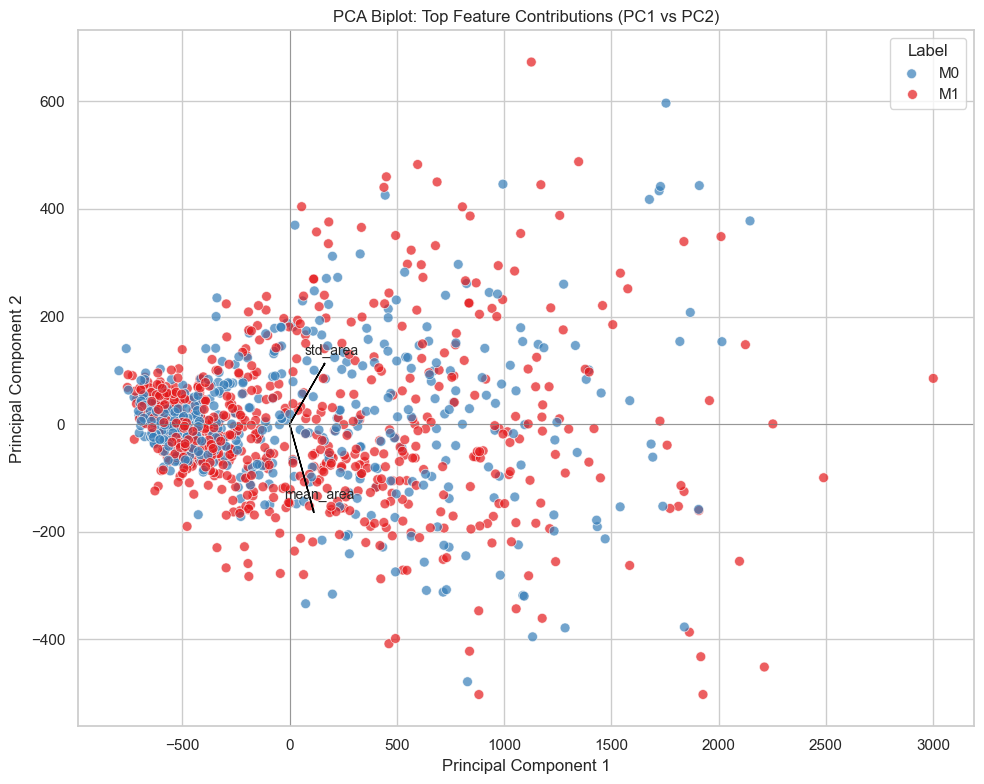

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# -------------------------------------
# 1. 파일 경로 설정 및 데이터 로드
# -------------------------------------
features_path = "C:/glom ML task/ml_features_cellpose.csv"
tvt_path = "C:/glom ML task/241121_updated_m0m1e1.csv"

df_feat = pd.read_csv(features_path)
df_tvt = pd.read_csv(tvt_path)

# -------------------------------------
# 2. filepath 정리 및 병합
# -------------------------------------
df_tvt['filepath_clean'] = df_tvt['filepath'].apply(
    lambda x: x.replace('\\', '/').split('/')[-2] + '/' + x.split('/')[-1]
)

df_merged = pd.merge(
    df_feat,
    df_tvt[['filepath_clean', 'tvt']],
    left_on='filepath',
    right_on='filepath_clean',
    how='inner',
    suffixes=('', '_tvt')  # 충돌 방지
)

# ✅ 병합된 'tvt'는 'tvt_tvt' 컬럼임
print("✅ 병합된 데이터 shape:", df_merged.shape)
print("📊 TVT 분포:\n", df_merged['tvt_tvt'].value_counts())

# -------------------------------------
# 3. 학습/테스트 분리
# -------------------------------------
trainval_df = df_merged[df_merged['tvt_tvt'].isin(['train', 'valid'])]
test_df = df_merged[df_merged['tvt_tvt'] == 'test']

X_train = trainval_df.drop(columns=["filepath", "filepath_clean", "label", "tvt", "tvt_tvt", "filepath_norm"])
y_train = trainval_df["label"]

# -------------------------------------
# 4. PCA 수행 및 시각화
# -------------------------------------
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
components = pca.components_  # (2, n_features)
feature_names = X_train.columns

# 2. scatter plot용 데이터
df_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
df_pca["label"] = y_train.values

# 3. 시각화 시작
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7, s=50)

# 4. feature 화살표 그리기
# 크기 조정 (스케일)
scale = 200
top_n = 2
top_features = np.argsort(np.abs(components[0]))[::-1][:top_n]

for i in top_features:
    feature = feature_names[i]
    x = components[0, i] * scale
    y = components[1, i] * scale

    plt.arrow(0, 0, x, y, color='black', width=0.4, head_width=4, length_includes_head=True)

    # label 위치 살짝 조정
    dx = 1.2 if x >= 0 else 0.8
    dy = 1.2 if y >= 0 else 0.8
    plt.text(x * dx, y * dy, feature, fontsize=10, ha='center', va='center')


# 5. 마무리 꾸미기
plt.title("PCA Biplot: Top Feature Contributions (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True)
plt.legend(title="Label", labels=["M0", "M1"])
plt.tight_layout()
plt.show()

In [11]:
# PCA 학습이 끝난 상태에서:
components = pca.components_  # shape: (n_components, n_features)
feature_names = X_train.columns

# PC1, PC2에 대한 기여도 정리
pc1_weights = pd.Series(components[0], index=feature_names).sort_values(key=abs, ascending=False)
pc2_weights = pd.Series(components[1], index=feature_names).sort_values(key=abs, ascending=False)

pc1_abs = pc1_weights.abs().sort_values(ascending=False)
pc2_abs = pc2_weights.abs().sort_values(ascending=False)

print("PC1에 가장 크게 기여한 feature들:")
print(pc1_weights.round(3).head(10))

print("PC2에 가장 크게 기여한 feature들:")
print(pc2_weights.round(3).head(10))

PC1에 가장 크게 기여한 feature들:
std_area             0.823
mean_area            0.568
cell_count          -0.018
mean_min_dist        0.009
mean_eccentricity   -0.000
mean_solidity        0.000
density             -0.000
dtype: float64
PC2에 가장 크게 기여한 feature들:
mean_area           -0.823
std_area             0.568
mean_min_dist       -0.011
cell_count          -0.000
mean_eccentricity    0.000
mean_solidity       -0.000
density              0.000
dtype: float64


In [17]:
import pandas as pd

# 1. 전체 feature 파일 불러오기
df_all = pd.read_csv("C:/glom ML task/ml_features_cellpose.csv")  # 전체 feature + filepath + label

# 2. 단변량 분석 결과 불러오기 (p-value 확인용)
df_ttest = pd.read_csv("C:/glom ML task/univariate_analysis_cellpose/univariate_ttest_results_cellpose.csv")

# 3. p-value < 0.05 인 feature 추출
significant_features = df_ttest[df_ttest["p_value"] < 0.05]["feature"].tolist()

# 4. 필요한 컬럼 = filepath, label + significant features
cols_selected = ["filepath", "label"] + significant_features
df_selected = df_all[cols_selected]

# 5. 저장
df_selected.to_csv("C:/glom ML task/selected_features_with_filepath_cellpose.csv", index=False)
df_all.to_csv("C:/glom ML task/all_features_with_filepath_cellpose.csv", index=False)

print("✅ 두 개의 CSV 파일이 성공적으로 저장되었습니다!")
print("📁 p<0.05만 포함: selected_features_with_filepath_cellpose.csv")
print("📁 전체 feature 포함: all_features_with_filepath_cellpose.csv")


✅ 두 개의 CSV 파일이 성공적으로 저장되었습니다!
📁 p<0.05만 포함: selected_features_with_filepath_cellpose.csv
📁 전체 feature 포함: all_features_with_filepath_cellpose.csv


In [19]:
import pandas as pd

# 1. 기존 selected feature 파일 불러오기
df_selected = pd.read_csv("C:/glom ML task/selected_features_with_filepath_cellpose.csv")

# 2. TVT 정보 불러오기
df_tvt = pd.read_csv("C:/glom ML task/241121_updated_m0m1e1.csv")
df_tvt['filepath_clean'] = df_tvt['filepath'].apply(
    lambda x: x.replace('\\', '/').split('/')[-2] + '/' + x.split('/')[-1]
)

# 3. 병합: label, tvt 붙이기
df_selected = pd.merge(
    df_selected,
    df_tvt[['filepath_clean', 'label', 'tvt']],
    left_on='filepath',
    right_on='filepath_clean',
    how='inner'
).drop(columns=['filepath_clean'])

# 4. 기존 파일에 덮어쓰기 저장
df_selected.to_csv("C:/glom ML task/selected_features_with_filepath_cellpose.csv", index=False)

print("✅ 기존 파일에 label과 tvt 추가 완료! 덮어쓰기 저장 완료 ✅")

✅ 기존 파일에 label과 tvt 추가 완료! 덮어쓰기 저장 완료 ✅


In [20]:
import pandas as pd

# 1. 파일 경로 설정
csv_path = "C:/glom ML task/selected_features_with_filepath_cellpose.csv"

# 2. CSV 파일 불러오기
df = pd.read_csv(csv_path)

# 3. 필요 없는 'label_y' 제거
if 'label_y' in df.columns:
    df = df.drop(columns=['label_y'])

# 4. 'label_x' → 'label'로 이름 변경
if 'label_x' in df.columns:
    df = df.rename(columns={'label_x': 'label'})

# 5. 덮어쓰기 저장
df.to_csv(csv_path, index=False)

# 6. 확인용 출력
print("✅ CSV 정리 완료! 덮어쓰기 저장되었습니다.")
print("📄 포함된 컬럼:", df.columns.tolist())
print("🔢 데이터 크기:", df.shape)
print("📊 TVT 분포:\n", df['tvt'].value_counts())
print("📊 Label 분포:\n", df['label'].value_counts())


✅ CSV 정리 완료! 덮어쓰기 저장되었습니다.
📄 포함된 컬럼: ['filepath', 'label', 'cell_count', 'density', 'tvt']
🔢 데이터 크기: (1480, 5)
📊 TVT 분포:
 tvt
train    991
valid    249
test     240
Name: count, dtype: int64
📊 Label 분포:
 label
0    874
1    606
Name: count, dtype: int64


RandomForest 모델 학습

Classification Report (p < 0.05):
[Test] Accuracy: 0.6125
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       143
           1       0.53      0.41      0.46        97

    accuracy                           0.61       240
   macro avg       0.59      0.58      0.58       240
weighted avg       0.60      0.61      0.60       240



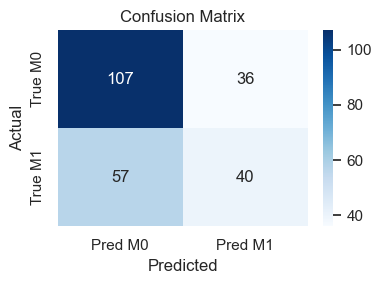

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CSV 경로
path = "C:/glom ML task/selected_features_with_filepath_cellpose.csv"

# 데이터 로드
df = pd.read_csv(path)

# Train/Valid/Test 분리
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

X_train = trainval_df.drop(columns=["filepath", "tvt", "label"])
y_train = trainval_df["label"]
X_test = test_df.drop(columns=["filepath", "tvt", "label"])
y_test = test_df["label"]

# 모델 학습
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (p < 0.05):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Classification Report (All Features):
[Test] Accuracy: 0.6042
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       143
           1       0.51      0.36      0.42        97

    accuracy                           0.60       240
   macro avg       0.58      0.57      0.56       240
weighted avg       0.59      0.60      0.59       240



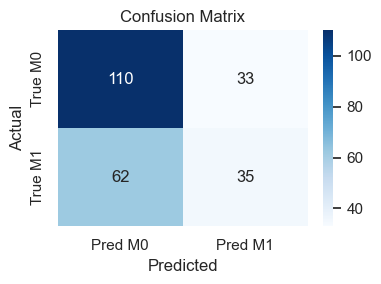

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CSV 경로
path = "C:/glom ML task/all_features_with_filepath_cellpose.csv"

# 데이터 로드
df = pd.read_csv(path)

# Train/Valid/Test 분리
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# Drop string columns + label
X_train = trainval_df.select_dtypes(exclude=['object']).drop(columns=["label"])
y_train = trainval_df["label"]

X_test = test_df.select_dtypes(exclude=['object']).drop(columns=["label"])
y_test = test_df["label"]


# 모델 학습
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (All Features):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Classification Report (with SMOTE):
[Test] Accuracy: 0.6125
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       143
           1       0.52      0.48      0.50        97

    accuracy                           0.61       240
   macro avg       0.59      0.59      0.59       240
weighted avg       0.61      0.61      0.61       240



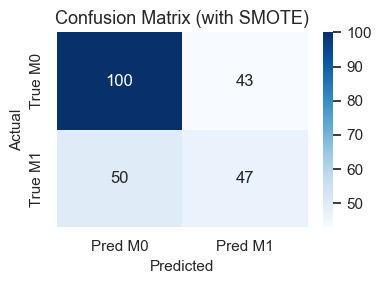

In [27]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 데이터 로드
df = pd.read_csv("C:/glom ML task/all_features_with_filepath_cellpose.csv")

# 데이터 분리
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# 문자열 제외한 feature
X_train = trainval_df.select_dtypes(exclude='object').drop(columns=["label"])
y_train = trainval_df["label"]
X_test = test_df.select_dtypes(exclude='object').drop(columns=["label"])
y_test = test_df["label"]

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 모델 학습 및 예측
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

# 결과 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (with SMOTE):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix (with SMOTE)", fontsize=13)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.tight_layout()
plt.show()

XGBoost 모델 학습

c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost):
[Test] Accuracy: 0.6167
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       143
           1       0.53      0.45      0.49        97

    accuracy                           0.62       240
   macro avg       0.60      0.59      0.59       240
weighted avg       0.61      0.62      0.61       240



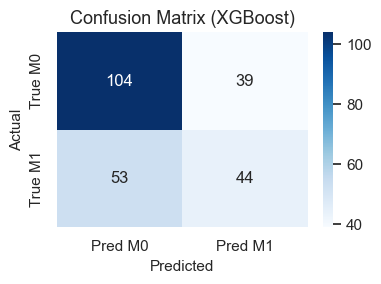

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CSV 파일 경로
path = "C:/glom ML task/all_features_with_filepath_cellpose.csv"

# 데이터 로드
df = pd.read_csv(path)

# TVT 분할
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# 문자열 제외한 feature만 선택
X_train = trainval_df.select_dtypes(exclude='object').drop(columns=["label"])
y_train = trainval_df["label"]
X_test = test_df.select_dtypes(exclude='object').drop(columns=["label"])
y_test = test_df["label"]

# XGBoost 모델 학습
model = XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 평가 결과 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (XGBoost):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix (XGBoost)", fontsize=13)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.tight_layout()
plt.show()

c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (p < 0.05):
[Test] Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       143
           1       0.55      0.40      0.46        97

    accuracy                           0.62       240
   macro avg       0.60      0.59      0.59       240
weighted avg       0.61      0.62      0.61       240



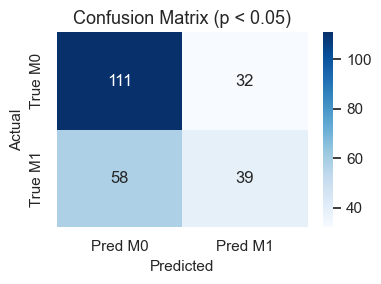

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CSV 파일 경로
path = "C:/glom ML task/selected_features_with_filepath_cellpose.csv"

# 데이터 로드
df = pd.read_csv(path)

# TVT 분할
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# 학습/테스트 데이터 분리
X_train = trainval_df.drop(columns=["filepath", "tvt", "label"])
y_train = trainval_df["label"]
X_test = test_df.drop(columns=["filepath", "tvt", "label"])
y_test = test_df["label"]

# XGBoost 모델 학습
model = XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 평가 결과 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (p < 0.05):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix (p < 0.05)", fontsize=13)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.tight_layout()
plt.show()


c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [18:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost - with SMOTE):
[Test] Accuracy: 0.5708
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       143
           1       0.47      0.49      0.48        97

    accuracy                           0.57       240
   macro avg       0.56      0.56      0.56       240
weighted avg       0.57      0.57      0.57       240



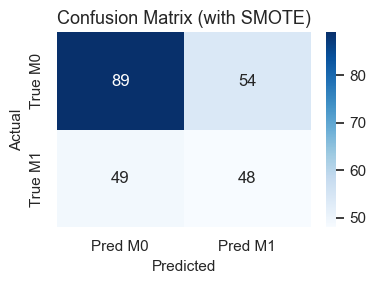

In [29]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 데이터 로드
df = pd.read_csv("C:/glom ML task/all_features_with_filepath_cellpose.csv")

# 데이터 분리
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# feature 선택 (문자열 제외)
X_train = trainval_df.select_dtypes(exclude='object').drop(columns=["label"])
y_train = trainval_df["label"]
X_test = test_df.select_dtypes(exclude='object').drop(columns=["label"])
y_test = test_df["label"]

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost 모델 학습 및 예측
model = XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

# 결과 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (XGBoost - with SMOTE):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix (with SMOTE)", fontsize=13)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.tight_layout()
plt.show()

c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost):
[Test] Accuracy: 0.6167
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       143
           1       0.53      0.45      0.49        97

    accuracy                           0.62       240
   macro avg       0.60      0.59      0.59       240
weighted avg       0.61      0.62      0.61       240



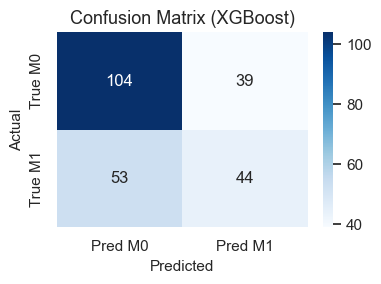

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 데이터 로드
df = pd.read_csv("C:/glom ML task/all_features_with_filepath_cellpose.csv")

# 데이터 분리
trainval_df = df[df['tvt'].isin(['train', 'valid'])]
test_df = df[df['tvt'] == 'test']

# feature 선택 (문자열 제외)
X_train = trainval_df.select_dtypes(exclude='object').drop(columns=["label"])
y_train = trainval_df["label"]
X_test = test_df.select_dtypes(exclude='object').drop(columns=["label"])
y_test = test_df["label"]

# XGBoost 모델 학습 및 예측
model = XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 결과 출력
acc = accuracy_score(y_test, y_pred)
print("Classification Report (XGBoost):")
print(f"[Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"],
            cbar=True)
plt.title("Confusion Matrix (XGBoost)", fontsize=13)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.tight_layout()
plt.show()
